# RNN 기초 예제 - MNIST 문제 해결 구현

1. RNN 모형
1. RNN 학습 데이터로 사용하기 위한 mini-batch 구성
1. 텐서플로우 RNN
1. mnist 데이터 준비
1. 1-layer RNN 학습 테스트
1. stacked rnn in tensorflow
1. 3-layer RNN 학습 테스트

# http://192.168.0.29/rhee/week5-day1-rnn-mnist.git

## RNN 모형

<img  src="rnn.jpg" style="width:55.5rem"/>

<center>이미지 출처: http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/</center>

\begin{align}
s_t & = tanh(Ux_t + Ws_{t-1}) \\
o_t & = softmax(Vs_t) \\
\end{align}



## 학습 데이터 mini-batch 구성의 차이 FCN, 2D-CNN vs RNN

- FCN ( Fully Connected Network, a.k.a. `dense` )

  - `[batch, inputs]`
  - e.g.: [`tf.layers.dense()`](http://devdocs.io/tensorflow~python/tf/layers/dense)


- 2D-CNN 의 경우 학습데이터 feed 구성

  - `[batch, height, width, channel]` : `data_format = "NHWC"` (default)
  - `[batch, channel, height, width]` : `data_format = "NCHW"`
  - e.g.: [`tf.layers.conv2d()`](http://devdocs.io/tensorflow~python/tf/layers/conv2d)



- RNN 의 경우 학습 데이터 feed 구성

  - `[batch, sequence, input]` : `time_major = False` (default for [`tf.nn.dynamic_rnn()`](http://devdocs.io/tensorflow~python/tf/nn/dynamic_rnn))
  - `[sequence, batch, input]` : `time_major = True`  (default for [`tf.nn.static_rnn()`](http://devdocs.io/tensorflow~python/tf/nn/static_rnn))



## RNN 모형과 tensorflow RNNCell


<img  src="Selection_20170914_161757_e791.png"/>


\begin{align}
s_t & = tanh(Ux_t + Ws_{t-1}) \\
\end{align}


- **_V_** 에 해당하는 구조가 없음

- **_softmax()_** 도 없음

- **_V_** 와 **_softmax()_** 는 필요할 때만 만들어서 붙이면 됨 ( `tf.layers.dense`, `tf.nn.softmax` )


### 텐서플로우 rnn 기본 클래스/함수

- [`tf.contrib.rnn.BasicRNNCell()`](http://devdocs.io/tensorflow~python/tf/contrib/rnn/basicrnncell)
  - abstraction of RNN cell
  - $s_t = tanh(Ux_t + Ws_{t-1})$



- [`tf.nn.static_rnn()`](http://devdocs.io/tensorflow~python/tf/nn/static_rnn)
  - _time-major_ format inputs, outputs
  - static unfolding


- [`tf.nn.dynamic_rnn()`](http://devdocs.io/tensorflow~python/tf/nn/dynamic_rnn)
  - _batch-major_ format inputs, outputs (default)
  - `time_major = True` for _time-major_ format
  - dynamic unfolding using [`tf.while_loop()`](http://devdocs.io/tensorflow~python/tf/while_loop)
  - more advanced options



### [`tf.contrib.rnn.BasicRNNCell()`](http://devdocs.io/tensorflow~python/tf/contrib/rnn/basicrnncell)

<code>
    `__init__`(
        <span style="color:red">num_units,</span>
        activation=None,
        reuse=None
    )
</code>

<code>
    `__call__`(
        <span style="color:red">inputs,</span>
        <span style="color:red">state,</span>
        scope=None
    )
</code>

### [`tf.nn.static_rnn()`](http://devdocs.io/tensorflow~python/tf/nn/static_rnn)

<code>
    static_rnn(
        <span style="color:red">cell,</span>
        <span style="color:red">inputs,</span>
        initial_state=None,
        dtype=None,
        <span style="color:red">sequence_length=None,</span>
        scope=None
    )
</code>

> The simplest form of RNN network generated is:

<code>
    state = cell.zero_state(...)
    outputs = []
    for inp in inputs:
      <span style="color:red">output, state = cell(inp, state)</span>
      outputs.append(output)
    return (outputs, state)
</code>

> `sequence_length` 가 `None` 이 아니라면,
> 배치에 포함된 각 example 들의 sequence length 를 기록한 리스트를 전달.
> 해당 배치에서 sequence length 를 넘는 t 에 대해서는:
>   - <span style="color:red">output 은 zero</span>
>   - state는 sequence length - 1 때의 state

```
(output, state)(b, t) =
  (t >= sequence_length(b))
    ? (zeros(cell.output_size), states(b, sequence_length(b) - 1))
    : cell(input(b, t), state(b, t - 1))
``` 
    

### [`tf.nn.dynamic_rnn()`](http://devdocs.io/tensorflow~python/tf/nn/dynamic_rnn)

<code>
dynamic_rnn(
    <span style="color:red">cell,</span>
    <span style="color:red">inputs,</span>
    <span style="color:red">sequence_length=None,</span>
    initial_state=None,
    dtype=None,
    parallel_iterations=None,
    swap_memory=False,
    time_major=False,
    scope=None
)
</code>


In [1]:
%load_ext do_not_print_href
%matplotlib inline
from __future__ import print_function, division
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
!rm -fr logdir
!mkdir -p logdir

## 데이터 준비

- 1주차 실습에 사용한 것과 동일한 데이터
- 5주차 실습에서는 tensorflow example 의 기본 제공 메소드를 이용

### 1주차에 사용한 코드 (참고)

<div  style="border:1px solid black;border-radius:3px;width:65.0rem;margin:auto">
<code>
    %%bash
    test -s ./mnist/train-images-idx3-ubyte || (
     mkdir -p ./mnist
     cd ./mnist
     echo "$(pwd)"
     wget -q \
      http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz \
      http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz \
      http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz \
      http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
     gzip -d *.gz
    )

</code>
</div>

<div  style="border:1px solid black;border-radius:3px;width:65.0rem;margin:auto">
<code>
    data_dir = './mnist'
    data_dir

    images         = np.fromfile(data_dir + 
                         '/train-images-idx3-ubyte',dtype=np.uint8)
    images         = images[16:].reshape([-1,28,28]).astype(np.float32)
    images         = images / 127.0 - 1.0

    labels         = np.fromfile(data_dir + 
                         '/train-labels-idx1-ubyte',dtype=np.uint8)
    labels         = labels[8:].astype(np.int64)

</code>
</div>

<div  style="border:1px solid black;border-radius:3px;width:65.0rem;margin:auto">
<code>
    images.shape, images.dtype, labels.shape, labels.dtype

</code>
</div>

###  5주차에 사용할 코드

In [3]:
from tensorflow.examples.tutorials.mnist.input_data \
    import read_data_sets

In [4]:
mnist = read_data_sets('./mnist', one_hot=False)
mnist

Extracting ./mnist/train-images-idx3-ubyte.gz
Extracting ./mnist/train-labels-idx1-ubyte.gz
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Extracting ./mnist/t10k-labels-idx1-ubyte.gz


Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7fd30412a810>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7fd2af30fd50>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7fd2af30fd90>)

In [5]:
mnist.train.num_examples, \
mnist.train.images.shape, \
mnist.train.labels.shape

(55000, (55000, 784), (55000,))

In [6]:
mnist.test.num_examples, \
mnist.test.images.shape, \
mnist.test.labels.shape

(10000, (10000, 784), (10000,))

## 이미지 하나만 골라서 확인

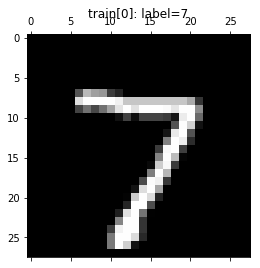

In [7]:
i = 0
img = mnist.test.images[i,:].reshape([28,28])
lbl = mnist.test.labels[i]
plt.matshow(img,cmap=plt.get_cmap('gray'))
plt.title('train[{:d}]: label={:d}'.format(i,lbl))
plt.show()

## RNN 학습 입력으로 사용하기 위해서 입력값의 해석 방식을 달리함

- 28 x 28 = 784 개 입력값을

- 28개 입력값의 길이 28인 시퀀스로 해석


## 학습 데이터의 규격 설정

In [8]:
INPUT_UNITS = 28
NUM_HIDDEN_UNITS = 31

BATCH_SIZE = 128
MAX_SEQ_LEN = 28

## 훈련 루프 카운트 계산

In [9]:
train_loop_count = mnist.train.num_examples // BATCH_SIZE
test_loop_count  = mnist.test.num_examples // BATCH_SIZE

train_loop_count, test_loop_count

(429, 78)

## 만들고자 하는 RNN 네트워크 구조

<img  src="Selection_20170912_110940_c175.png"/>

## RNN 모델 구성

In [10]:
class MnistRnn:
    def __init__(self, 
                 inputs, 
                 labels, 
                 input_units, 
                 num_hidden_units, 
                 batch_size, 
                 max_seq_len):
        '''
        inputs: in shape [batch_size, max_seq_len, input_size]
        labels: in shape [batch_size]
        '''
        
        # RNN 모델 구성
        cell            = tf.contrib.rnn.BasicRNNCell(
                            num_hidden_units)
        sequence_length = [max_seq_len] * batch_size
        last, states    = tf.nn.dynamic_rnn(
                            cell, 
                            inputs, 
                            sequence_length=sequence_length, 
                            dtype=tf.float32)

        ######################################################
        # last.shape   : 
        #  [batch_size, max_seq_len, num_hidden_units]
        # states.shape : 
        #  [?, num_hidden_units]
        ######################################################
        print('last.shape', last.get_shape().as_list())
        print('states', states)


        
        ######################################################
        # max_seq_len 축으로 0~27 까지 값 중에 0~26 출력 값은 사용하지
        #  않음 - 모든 RNN이 그런건 아니고 경우에 따라 다름
        # last.shape      : 
        #  [batch_size, max_seq_len, num_hidden_units]
        # rnn_output shape: 
        #  [batch_size, num_hidden_units]
        ######################################################
        rnn_output = last[:,max_seq_len-1,:]
        print('rnn_output.shape', rnn_output.get_shape().as_list())

        
        
        
        # 10 개의 output units 로 만들 
        #  FCN (fully-connected-network) 구성
        # outputs shape will become: [batch_size, 10]
        outputs    = tf.layers.dense(rnn_output, 10)
        print('outputs.shape', outputs.get_shape().as_list())

        
        ######################################################
        # loss 함수: sparse_softmax_cross_entropy
        #   label 데이터의 one-hot encoding 과,
        #   output 데이터의 softmax() 적용이,
        #   sparse_softmax_cross_entropy() 함수 하나에 다 들어 있음
        ######################################################


        loss       = tf.losses.sparse_softmax_cross_entropy(
                        labels, outputs)
        optimize   = tf.train.AdamOptimizer(learning_rate=0.001). \
                        minimize(loss)

        
        # accuracy
        preds    = tf.argmax(outputs, axis=1)
        errors   = tf.count_nonzero(labels - preds)
        accuracy = 1.0 - tf.cast(errors,tf.float32) / \
                         tf.cast(tf.size(preds),tf.float32)

        # 클래스 객체 외부에서 참고할 수 있도록 속성으로 저장
        self.outputs        = outputs
        self.loss           = loss
        self.optimize       = optimize
        self.accuracy       = accuracy


## 텐서플로우 그래프 초기화, Placeholders 정의, 그래프 빌드

In [11]:
tf.reset_default_graph()

inputs_ = tf.placeholder(
            tf.float32,
            [BATCH_SIZE, MAX_SEQ_LEN, INPUT_UNITS],
            name='inputs')
labels_ = tf.placeholder(
            tf.int64,
            [BATCH_SIZE],
            name='labels')

model = MnistRnn(inputs_,
                 labels_,
                 INPUT_UNITS,
                 NUM_HIDDEN_UNITS,
                 BATCH_SIZE,
                 MAX_SEQ_LEN)

last.shape [128, 28, 31]
states Tensor("rnn/while/Exit_2:0", shape=(128, 31), dtype=float32)
rnn_output.shape [128, 31]
outputs.shape [128, 10]


## 학습을 위한 세션 초기화, 변수 초기화

In [12]:
config = tf.ConfigProto(gpu_options={'allow_growth':True})
sess = tf.InteractiveSession(config=config)

tf.global_variables_initializer().run()

## 훈련 진도 기록용 summary writer 

- tensorboard logdir 지정시, 지정된 디렉토리 아래에서 이벤트 파일을 모두 찾아서 그래프로 보여줌

- 따라서, 공통의 parentdir ( 예: `logdir/train` 과 `logdir/test` 의 공통 parent 인 `logdir` ) 지정시 여러 그래프를 동시에 보여 줌


In [13]:
train_writer = tf.summary.FileWriter(
    'logdir/train',
    graph=tf.get_default_graph())
test_writer  = tf.summary.FileWriter(
    'logdir/test',
    graph=tf.get_default_graph())

## 팁: `tf.Summary()`, `tf.Summary.Value()` 를 이용하면 텐서를 만들지 않아도 summary를 기록할 수 있습니다.

```
    summary = tf.Summary(
                value=[
                    tf.Summary.Value(
                        tag=tag,
                        simple_value=value)])
    writer.add_summary(summary, step)
```

- 하지만, histogram, audio, image 등에 적용하려면 번거로운 일이 있읍니다. 여기서는 scalar summary 만 사용
- "Logging to tensorboard with manually generated summaries (not relying on summary ops)" 참고
  - https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514

## 훈련 루프 정의

In [14]:
def train(
    inputs,
    labels,
    max_epochs,
    train_writer=None,
    test_writer=None):
    
    step = 0
    for ep in range(max_epochs):

        train_elapsed = []
        train_losses = []
        train_accuracy = []
        for i in range(train_loop_count):
            t_start     = time.time()
            offs        = i * BATCH_SIZE
            batch_input = \
                mnist.train.images[offs:offs+BATCH_SIZE,:]
            batch_input = \
                batch_input.reshape([BATCH_SIZE,
                                        MAX_SEQ_LEN,
                                        INPUT_UNITS])
            batch_label = \
                mnist.train.labels[offs:offs+BATCH_SIZE]
            optimize, loss, accuracy, = \
                sess.run([model.optimize,
                          model.loss,
                          model.accuracy],
                         feed_dict = {
                          inputs: batch_input,
                          labels: batch_label })
            train_losses.append(loss)
            train_accuracy.append(accuracy)
            t_elapsed   = time.time() - t_start
            train_elapsed.append(t_elapsed)

            step += 1

            if train_writer:
                summary = tf.Summary(
                    value=[
                        tf.Summary.Value(
                            tag='train_accuracy',
                            simple_value=accuracy
                        ),
                        tf.Summary.Value(
                            tag='loss',
                            simple_value=loss
                        ),
                    ]
                )
                train_writer.add_summary(summary,global_step=step)

            if step % 250 == 0:
                print(('[trn] ep {:d}, step {:d}, ' + 
                       'loss {:f}, accu {:f}, ' + 
                       'sec/iter {:f}').format(
                    ep + 1,
                    step,
                    np.mean(train_losses),
                    np.amin(train_accuracy),
                    np.mean(train_elapsed)))
                train_losses = []
                train_accuracy = []
                train_elapsed = []

        test_elapsed  = []
        test_accuracy = []
        for i in range(test_loop_count):
            t_start     = time.time()
            offs        = i * BATCH_SIZE
            batch_input = \
                mnist.test.images[offs:offs+BATCH_SIZE,:]
            batch_input = \
                batch_input.reshape([BATCH_SIZE,
                                       MAX_SEQ_LEN,
                                       INPUT_UNITS])
            batch_label = \
                mnist.test.labels[offs:offs+BATCH_SIZE]
            accuracy, = \
                sess.run([model.accuracy],
                         feed_dict = {
                          inputs: batch_input,
                          labels: batch_label })
            test_accuracy.append(accuracy)
            t_elapsed   = time.time() - t_start
            test_elapsed.append(t_elapsed)

            step += 1
            
            if test_writer:
                summary = tf.Summary(
                    value=[
                        tf.Summary.Value(
                            tag='test_accuracy',
                            simple_value=accuracy
                        ),
                    ]
                )
                test_writer.add_summary(summary,global_step=step)

            if step % 250 == 0:
                print(('[tst] ep {:d}, ' +
                       'step {:d}, accu {:f}, ' + 
                       'sec/iter {:f}').format(
                    ep + 1,
                    step,
                    np.amin(test_accuracy),
                    np.mean(test_elapsed)))
                test_accuracy = []
                test_elapsed  = []


## 훈련 루프 실행

In [15]:
tf.get_default_graph().finalize()
train(inputs_, labels_, 10, train_writer, test_writer)

[trn] ep 1, step 250, loss 1.662436, accu 0.085938, sec/iter 0.007257
[tst] ep 1, step 500, accu 0.507812, sec/iter 0.002417
[trn] ep 2, step 750, loss 0.892362, accu 0.531250, sec/iter 0.005681
[tst] ep 2, step 1000, accu 0.601562, sec/iter 0.002177
[trn] ep 3, step 1250, loss 0.639886, accu 0.671875, sec/iter 0.005539
[tst] ep 3, step 1500, accu 0.710938, sec/iter 0.002244
[trn] ep 4, step 1750, loss 0.507841, accu 0.734375, sec/iter 0.005601
[tst] ep 4, step 2000, accu 0.750000, sec/iter 0.002200
[trn] ep 5, step 2250, loss 0.433358, accu 0.765625, sec/iter 0.005575
[tst] ep 5, step 2500, accu 0.773438, sec/iter 0.002220
[trn] ep 6, step 2750, loss 0.390744, accu 0.773438, sec/iter 0.005693
[tst] ep 6, step 3000, accu 0.812500, sec/iter 0.002339
[trn] ep 7, step 3250, loss 0.357466, accu 0.796875, sec/iter 0.005553
[tst] ep 7, step 3500, accu 0.820312, sec/iter 0.002375
[trn] ep 8, step 3750, loss 0.334627, accu 0.820312, sec/iter 0.007004
[tst] ep 8, step 4000, accu 0.851562, sec/i

## 훈련 진행 점검 - 텐서보드

In [2]:
# !tensorboard --ip 0.0.0.0 --logdir logdir

## RNN 모델 구성(2) - Stacking Multiple RNN Cells

- [`tf.contrib.rnn.MultiRNNCell`](http://devdocs.io/tensorflow~python/tf/contrib/rnn/multirnncell)

<code>
    `__init__(`
        <span style="color:red">cells,</span>
        state_is_tuple=True
    )
</code>

> 주의: _**tensorflow**_ 1.0 이전과 1.1, 1.2 이후의 `cells` 값 지정의 의미가 달라짐

  - (A) _**tensorflow**_ 1.0 이전:

<code>
    cell       = tf.contrib.rnn.BasicRNNCell(num_hidden_units)
    multi_cell = tf.contrib.rnn.MultiRnnCell(<span style="color:red">[cell] * 3</span>)
</code>

  - (B) _**tensorflow**_ 1.1:
    - `ValueError: Attempt to reuse RNNCell with a different variable scope than its first use.`
    - **To fix:**
      ```
        multi_cell = tf.contrib.rnn.MultiRnnCell([ \
            tf.contrib.rnn.BasicRNNCell(num_hidden_units) \
            for k in range(3)])
      ```

  - _**tensorflow**_ 1.2 이후:
    - (A)방식을 써도 `ValueError` 가 발생하지는 않지만, (A), (B) 의미가 달라짐
    - (A)방식 : 3-layer rnn stack 을 만들지만, 각 셀의 weight 를 공유하게 된다.
    - layer 마다 별개의 rnn cell 을 만들고 싶으면 (B) 방식으로.


In [17]:
class MnistRnn:
    def __init__(self, 
                 inputs, 
                 labels, 
                 input_units, 
                 num_hidden_units, 
                 batch_size, 
                 max_seq_len):
        '''
        inputs: in shape [batch_size, max_seq_len, input_size]
        labels: in shape [batch_size]
        '''

        # ===>>> MultiRNNCell <<<===
        multi_cells     = tf.contrib.rnn.MultiRNNCell([
                            tf.contrib.rnn.BasicRNNCell(
                                num_hidden_units) \
                            for _ in \
                            range(3) ])

        sequence_length = [max_seq_len] * batch_size
        last, states    = tf.nn.dynamic_rnn(
                            multi_cells, 
                            inputs, 
                            sequence_length=sequence_length, 
                            dtype=tf.float32)
        
        # 여기서,
        # last.shape: [batch_size, max_seq_len, num_hidden_units]
        
        #####################################################
        # MultiRNNCell 을 쓰면 states값이 tensor 의 tuple 이 됨.
        # states.shape : ([?, num_hidden_units],...)
        #####################################################

        print('last.shape', last.get_shape().as_list())
        print('states', states)

        # max_seq_len 축으로 0~27 까지 값 중에 
        # 0~26 때의 출력 값은 사용하지 않음
        rnn_output = last[:,max_seq_len-1,:] 
        # rnn_output shape: [batch_size, num_hidden_units]
        print('rnn_output.shape', rnn_output.get_shape().as_list())

        # 10 개의 output units 로 만들 
        # FCN (fully-connected-network) 구성
        # ==> shape: [batch_size, 10]
        outputs    = tf.layers.dense(rnn_output, 10)
        print('outputs.shape', outputs.get_shape().as_list())

        # loss 함수
        loss       = tf.losses.sparse_softmax_cross_entropy(
                        labels, outputs)
        optimize   = tf.train.AdamOptimizer(learning_rate=0.001). \
                        minimize(loss)

        # accuracy
        preds    = tf.argmax(outputs, axis=1)
        errors   = tf.count_nonzero(labels - preds)
        accuracy = 1.0 - tf.cast(errors,tf.float32) / \
                         tf.cast(tf.size(preds),tf.float32)

        # 클래스 객체 외부에서 참고할 수 있도록 속성으로 저장
        self.outputs        = outputs
        self.loss           = loss
        self.optimize       = optimize
        self.accuracy       = accuracy

## 텐서플로우 그래프 초기화, Placeholders 정의, 그래프 빌드

In [18]:
tf.reset_default_graph()

inputs_ = tf.placeholder(
    tf.float32,
    [BATCH_SIZE, MAX_SEQ_LEN, INPUT_UNITS],
    name='inputs')
labels_ = tf.placeholder(
    tf.int64,
    [BATCH_SIZE],
    name='labels')

model = MnistRnn(inputs_,
                 labels_,
                 INPUT_UNITS,
                 NUM_HIDDEN_UNITS,
                 BATCH_SIZE,
                 MAX_SEQ_LEN)

last.shape [128, 28, 31]
states (<tf.Tensor 'rnn/while/Exit_2:0' shape=(128, 31) dtype=float32>, <tf.Tensor 'rnn/while/Exit_3:0' shape=(128, 31) dtype=float32>, <tf.Tensor 'rnn/while/Exit_4:0' shape=(128, 31) dtype=float32>)
rnn_output.shape [128, 31]
outputs.shape [128, 10]


## 세션 초기화, 변수 초기화

In [19]:
config = tf.ConfigProto(gpu_options={'allow_growth':True})
sess = tf.InteractiveSession(config=config)

tf.global_variables_initializer().run()

In [20]:
train_writer = tf.summary.FileWriter(
    'logdir/train2',
    graph=tf.get_default_graph())
test_writer  = tf.summary.FileWriter(
    'logdir/test2',
    graph=tf.get_default_graph())

In [21]:
train(inputs_, labels_, 10, train_writer, test_writer)

[trn] ep 1, step 250, loss 1.210108, accu 0.117188, sec/iter 0.012381
[tst] ep 1, step 500, accu 0.703125, sec/iter 0.004219
[trn] ep 2, step 750, loss 0.489575, accu 0.695312, sec/iter 0.012057
[tst] ep 2, step 1000, accu 0.773438, sec/iter 0.004077
[trn] ep 3, step 1250, loss 0.345612, accu 0.796875, sec/iter 0.012037
[tst] ep 3, step 1500, accu 0.828125, sec/iter 0.004014
[trn] ep 4, step 1750, loss 0.288167, accu 0.796875, sec/iter 0.012005
[tst] ep 4, step 2000, accu 0.851562, sec/iter 0.004372
[trn] ep 5, step 2250, loss 0.251965, accu 0.812500, sec/iter 0.012174
[tst] ep 5, step 2500, accu 0.867188, sec/iter 0.004039
[trn] ep 6, step 2750, loss 0.224646, accu 0.843750, sec/iter 0.012116
[tst] ep 6, step 3000, accu 0.875000, sec/iter 0.004018
[trn] ep 7, step 3250, loss 0.207039, accu 0.843750, sec/iter 0.012183
[tst] ep 7, step 3500, accu 0.875000, sec/iter 0.004154
[trn] ep 8, step 3750, loss 0.182022, accu 0.882812, sec/iter 0.012206
[tst] ep 8, step 4000, accu 0.890625, sec/i

In [22]:
# !tensorboard --ip 0.0.0.0 --logdir logdir

## 참고자료

- Team AI Korea RNN Tutorials

  - Part1 - http://aikorea.org/blog/rnn-tutorial-1/
  - Part2 - http://aikorea.org/blog/rnn-tutorial-2/


- WildML RNN Tutorial

  - http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-2-implementing-a-language-model-rnn-with-python-numpy-and-theano/


- https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/recurrent_network.py

- Tensorflow rnn_cell

  - http://devdocs.io/tensorflow~python/tf/nn/rnn_cell


- Tensorflow RNN Constructions

  - https://www.tensorflow.org/api_guides/python/nn#Recurrent_Neural_Networks

